### Project Summary

In this project, I will be using python to explore and analyse an industry retail dataset provided by AiCore. The project has three main sections:

1. **Downloading the dataset from AWS RDS**. This part is not including in this notebook. It is executed directly on the `db_utils.py` file contained in the project's repository. The table is downloaded as a .csv and stored locally. This is then uploaded as a dataframe using pandas `pd.read_csv` built-in function.

2. **Data exploration, cleaning and pre-processing.** The data will be investigated to find inaccuracies, trends and outliers. The data will be then cleaned using custom-built functions (`transformer.py`) and prepared for further ML processing. This notebook focuses solely on this part.

3. **Extracting business insights: data analysis and visualisation.** I will answer business questions by creating custom data visualisations, using pandas, matplotlib and seaborn libraries. This analysis can be found in a separate Jupyter notebook called `analysis_report.ipynb`.

In [1]:
# Import statements
from scipy.stats import chi2_contingency, normaltest
from scripts.info_extractor import DataFrameInfo
from scripts.transformer import DataTransform
from scripts.outlier_detector import OutlierDetector
from scripts.statistical_tests import StatisticalTests
from scripts.plotter import Plotter
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor 

import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## **Part I: Data Cleaning (QA)**

### 1.1. Import and Understand the Data

First we will load the data.

In [2]:
# Loading the data
customer_activity_df = pd.read_csv('data/customer_activity.csv')
print(f"The shape of the DataFrame is: {customer_activity_df.shape}")
customer_activity_df.head()

The shape of the DataFrame is: (12330, 17)


,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0.0,0.0,0,0.0,4.0,0.0,0.2000,0.200,0.0,May,Android,Google Chrome,North America,Twitter,Returning_Visitor,False,False
1,0.0,0.0,0,0.0,26.0,876.0,0.0000,0.026,0.0,Nov,Windows,Google Chrome,Western Europe,Google search,Returning_Visitor,True,False
2,2.0,99.4,0,0.0,19.0,368.0,0.0396,0.052,0.0,Sep,Windows,Google Chrome,Asia,Twitter,Returning_Visitor,False,False
3,0.0,0.0,0,0.0,20.0,1432.0,0.0248,0.028,1.8,Dec,Windows,Google Chrome,Western Europe,Instagram ads,Returning_Visitor,False,True
4,0.0,0.0,0,0.0,33.0,694.0,0.0141,0.032,0.0,May,Android,Google Chrome,North America,Instagram ads,Returning_Visitor,False,False


### Data dictionary for online customer activity

- **administrative**: Columns which indicates which administrative activity the user was performing on their account. Discreet numeric (categorical encoded).
- **administrative_duration**: How long a user performed administrative tasks in that session. Continuous numeric.
- **informational**: Indicates which informational activity the user was performing on the website. Discreet numeric (categorical encoded).
- **informational_duration**: How long a users performed informational tasks in seconds during that session. Continuous numeric.
- **product_related**: Indicates which product the user was viewing on the website. Discreet numeric (categorical encoded).
- **product_related_duration**: How long a user browsed products during that session. Continuous numeric.
- **bounce_rates**: Historical bounce rate of that particular page for all users. They visited the directly and immediately exited. Continuous numeric.
- **exit_rates**: Historical exit rate of the users from that particular page. Continuous numeric.
- **page_values**: The average value contribution of a page to a customer sale. Continuous numeric.
- **month**: Month the users activity took place. Can be represented as datetime or numeric.
- **operating_systems**: Operating system the user was using. Categorical text.
- **browser**: The browser used by the user. Categorical text.
- **region**: The region the user originated from. Categorical text.
- **traffic_type**: How the user was redirected to the site. Categorical text.
- **visitor_type**: Whether a customer was is new/returning or other. Categorical text.
- **weekend**: Whether the activity only took place during the weekend. Boolean: True == weekend, False == weekday.
- **revenue**: Whether the customer purchased anything that session. Boolean: True == weekend, False == weekday.

### 1.2. QA and Data Cleaning

#### 1.2.1. Check and fix column data types

In [3]:
customer_activity_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            11760 non-null  float64
 1   administrative_duration   11418 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    11994 non-null  float64
 4   product_related           11751 non-null  float64
 5   product_related_duration  12129 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   month                     12330 non-null  object 
 10  operating_systems         12319 non-null  object 
 11  browser                   12330 non-null  object 
 12  region                    12330 non-null  object 
 13  traffic_type              12330 non-null  object 
 14  visito

The column data type transformations needed are as follows:

|       Column      | current dtype | to dtype |                       Reason                       |
|:-----------------:|:-------------:|:--------:|:--------------------------------------------------:|
|   administrative  |    float64    |   int64  |     Discrete data: each integer encodes a task.    |
|  product_related  |    float64    |   int64  |     Discrete data: each integer encodes a task.    |
|       month       |     object    | datetime or int| Depends on purpose. |
|      browser      |     object    | category |                  Categorical data. Can be left as object too.                 |
|       region      |     object    | category |                  Categorical data. Can be left as object too.                 |
|    traffic_type   |     object    | category |                  Categorical data. Can be left as object too.                 |
| operating_systems |     object    | category |                  Categorical data. Can be left as object too.                |
|    visitor_type   |     object    | category |                  Categorical data. Can be left as object too.                |
|      weekend      |      bool     |   int64  |  Helps data analysis and allows ML model training. |
|      revenue      |      bool     |   int64  |  Helps data analysis and allows ML model training. |

The only transformations that **cannot** be done now are:

1. Coverting `administrative` and `product_related`: as long as there are nulls, data type is float64. Need to convert these **after imputing null values**.

In [4]:
# Create instance of transformer class
transformer = DataTransform(customer_activity_df)

customer_data = transformer.convert_columns(['weekend','revenue'],'int')
# customer_data = transformer.convert_columns(['browser','region','traffic_type','operating_systems','visitor_type'],'categorical')
customer_data = transformer.convert_month_to_int('month')
# Also available: function 'convert_month_to_datetime' to convert to datetime datatype. For our purpose, we will convert to period in this notebook.
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            11760 non-null  float64
 1   administrative_duration   11418 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    11994 non-null  float64
 4   product_related           11751 non-null  float64
 5   product_related_duration  12129 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   month                     12330 non-null  int64  
 10  operating_systems         12319 non-null  object 
 11  browser                   12330 non-null  object 
 12  region                    12330 non-null  object 
 13  traffic_type              12330 non-null  object 
 14  visito

**First look at the data: What have we learned?**

- 17 columns and 12330 records (rows).

- **Administrative/Informational/Product_related columns**: indicate which task has been performed. They are already encoded by an integer. There are 24 distinct adminitrative tasks, 13 distinct informational tasks and 296 distinct product-related tasks. For example, an administrative task can be logging into the website, whereas a product_related task could be adding a specific product to the basker.

- **Task duration columns**: indicate the time spent on each task. When a task has not been performed, the duration is set to zero. This will inevitably skew the data towards zero. We will chekc this in the next sections.

- **Null values**: there are null values in some columns of the dataset. Further exploration is needed.

#### 1.2.2. Are there missing and inconsistent values?

How many **null values** are there in our dataset? In which columns?

In [5]:
info_extractor = DataFrameInfo(customer_data)

# Call custom-made function generate null counts and percentages for each columns.
print(info_extractor.generate_null_counts())

                          null_count  null_percentage
administrative                   570         4.622871
administrative_duration          912         7.396594
informational                      0         0.000000
informational_duration           336         2.725061
product_related                  579         4.695864
product_related_duration         201         1.630170
bounce_rates                       0         0.000000
exit_rates                         0         0.000000
page_values                        0         0.000000
month                              0         0.000000
operating_systems                 11         0.089213
browser                            0         0.000000
region                             0         0.000000
traffic_type                       0         0.000000
visitor_type                       0         0.000000
weekend                            0         0.000000
revenue                            0         0.000000


<Axes: >

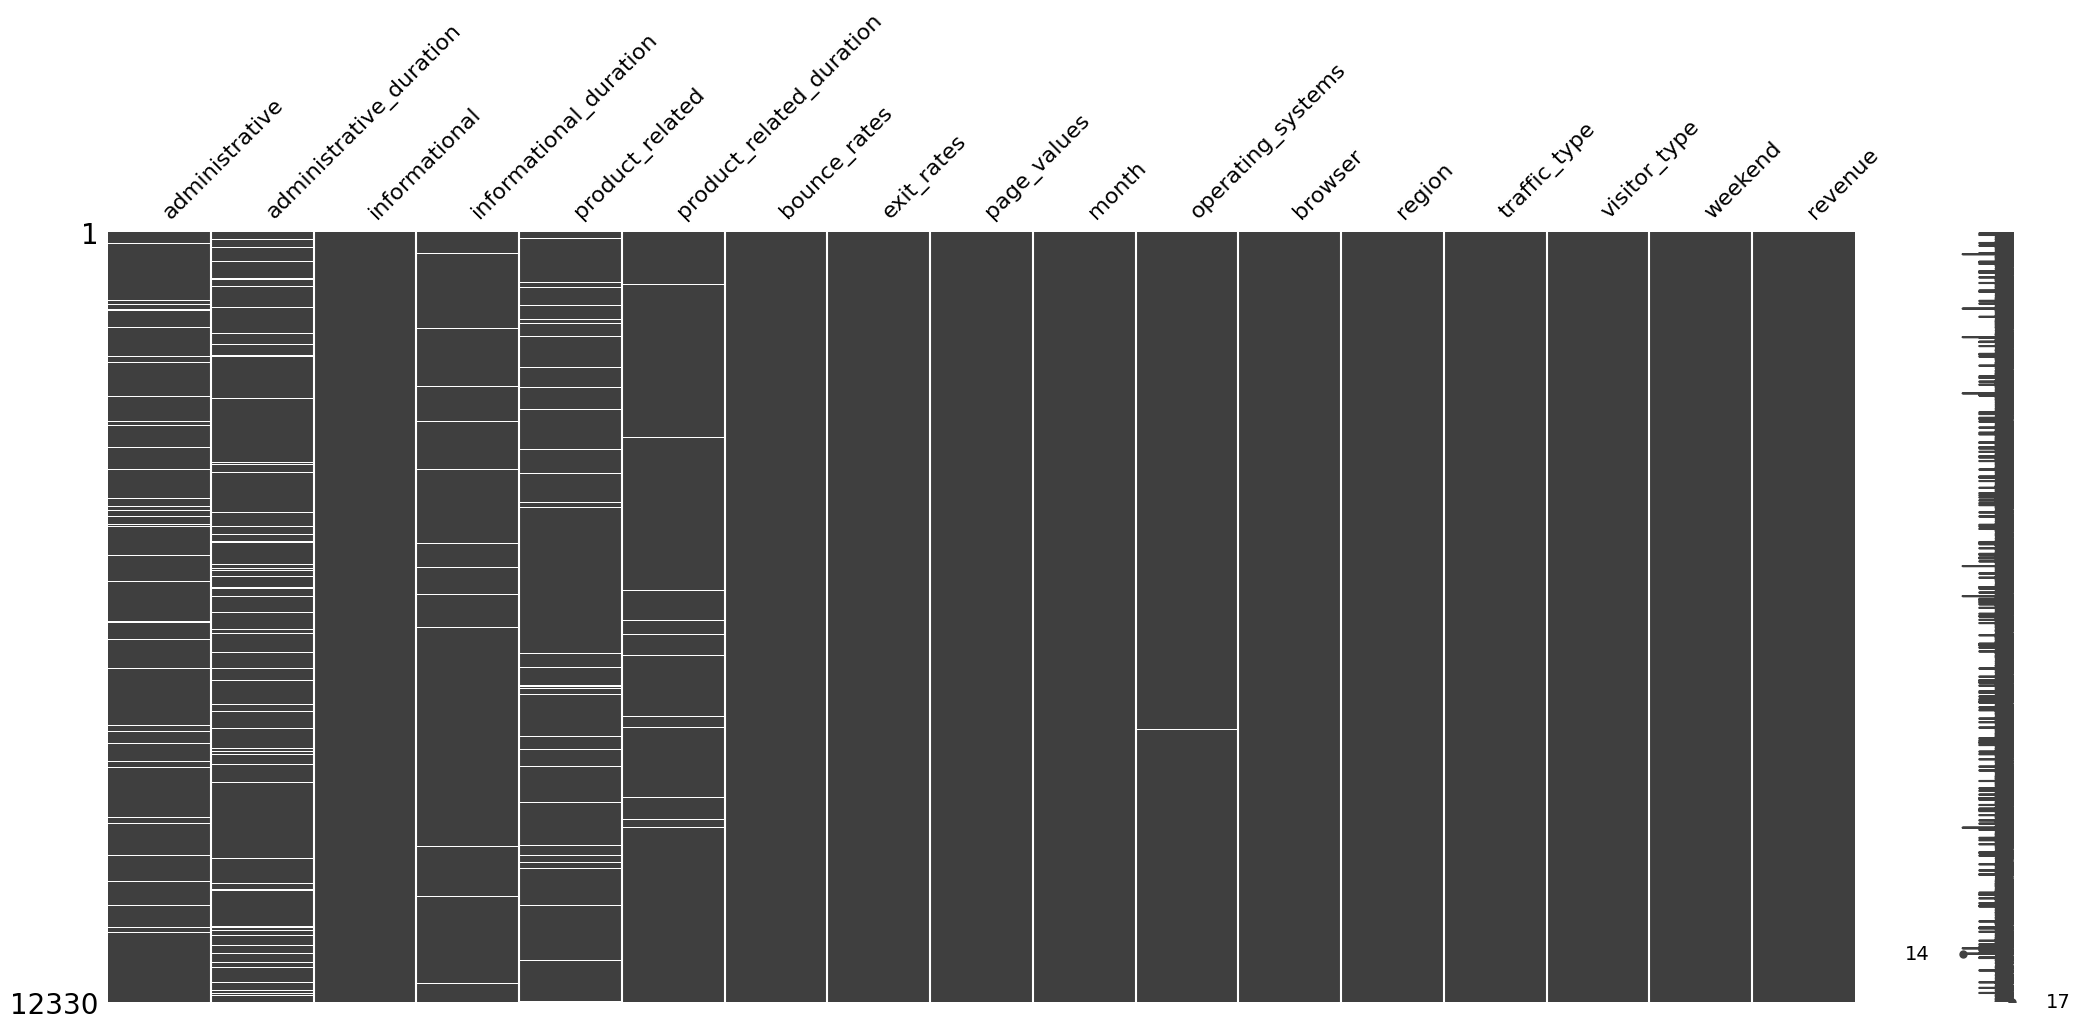

In [6]:
# Visualise missing values with the missingno library.
nulls_plot = msno.matrix(customer_activity_df)
nulls_plot

<Axes: >

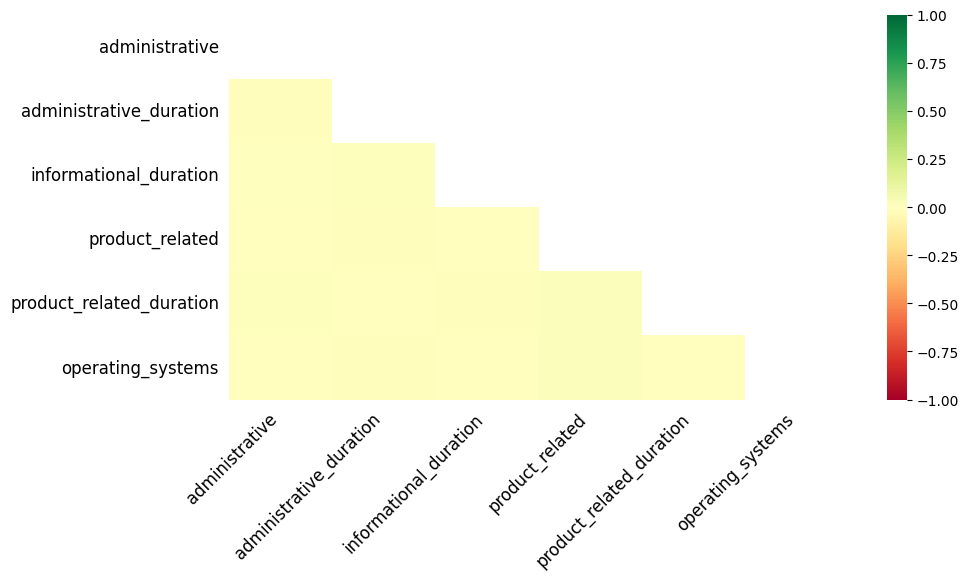

In [7]:
msno.heatmap(customer_activity_df, cmap="RdYlGn", figsize=(10,5), fontsize=12)

In [8]:
# Checks for independence of missing values
# for column in categorical_features:
#    stats_tests.chi_square_test('administrative', [column])

There is no correlation between values missing in different columns (nullity correlation).

##### **NOTES: Assessing missigness type and imputing null values**

##### Theory on Missingness Mechanisms

What causes the data to be missing is known as the Missingness Mechanism. There are three main types:

1. **Missing Completely at Random (MCAR).** Missingness presenting in your data is in a totally random pattern.
    - *How do we diagnose it?* Different ways. Little's test can be used for this purpose.
    - Does not introduce bias.
    - Some more information and references can be found here: [What to do with missing data?](https://www.lancaster.ac.uk/stor-i-student-sites/tessa-wilkie/2020/05/01/missing-data-part-ii-what-to-do-with-missing-data/)

1. **Missing at Random (MAR).** The probability of an observation missing depends on other observed variables but not the variable itself. If the cause of the missingness depends on some observed variable or variables that have been collected, the missing data mechanism is assumed to be MAR. Imagine a university does a survey of previous students, to find out where they are working, what their income bracket is, etc. Let’s say that alumni that work in a particular sector are less likely to disclose their income. But, they do disclose what sector it is that they work in. 
    - Introduces some bias.

**MCAR vs MAR**

| Diagnosing Missigness Mechanism |           When to use          |                           Disadvantages                          | Output                                                                                          |
|:-------------------------------:|:------------------------------:|:----------------------------------------------------------------:|-------------------------------------------------------------------------------------------------|
|        Little's MCAR Test       | Assumes multivariate normality | Does not identify which variables are associated with missigness | if p > significance level: no evidence to reject H0: data are MCAR. If p<sig. level: Reject H0. |

3. **Missing Not at Random (MNAR).** The probability of an observation missing depends on the values of the missing data itself, even after controlling for other observed variables. If the missing data mechanism is MNAR, the cause of the missingness cannot be controlled for. E.g. people with higher incomes are less likely to disclose their income in a survey. 
There are two reasons the missing data mechanism may be MNAR:
- **The researcher doesn’t know why the data are missing.** For example, in a longitudinal study, after a certain age, data is no longer collected, but the researcher neglected to ask the participants their age.
- **The data are missing because of the dependent variable.** For example, in a study of severe asthma where the measurements are taken at school, students who have severe asthma are absent more frequently because of their asthma. Hence the reason the data are missing is because students with severe asthma aren’t being measured when they don’t come to school. On the previous MAR example: what if students are less likely to respond to that income question the more they earn? Then we have Missing Not at Random data. The missingness depends on something we do not observe.
    - Introduces significant bias.
    - *How do we deal with it?* Complex statistical techniques are needed to impute missing values. This is very difficult to deal with and often causes bias in our analysis. To make it even more difficult, we cannot test whether the missingness mechanism is Missing at Random or Missing Not at Random.
    - *How do we diagnose it?* The first thing in diagnosing randomness of the missing data is to use your substantive scientific knowledge of the data and your field. The more sensitive the issue, the less likely people are to tell you. 

Checkout this resource for theory on Missigness Mechanisms and useful references: [Missing Data: Introducing the Missingness Mechanism](https://www.lancaster.ac.uk/stor-i-student-sites/tessa-wilkie/2020/04/29/missing-data-part-1-introducing-the-missingness-mechanism/)


| Simple methods to deal with missing data |                                      When to use                                     |                              Disadvantages                             |
|:--------------------------------------:|:------------------------------------------------------------------------------------:|:----------------------------------------------------------------------:|
|    Listwise Deletion (dropping rows)   |                              MCAR, nulls are < 1% of the data                              |          Might lose statistical power or important information         |
|          Drop entire variable          |    Number of missing values for a variable is very high and variable not essential   |                            Drastic approach                            |
|          Imputation with mean          |                         MCAR, continuous data, normally distributed                        |  Increases the variance of the imputed variable / Does not reflect uncertainty / May add bias |
|         Imputation with median         |                                MCAR, continuous data, skewed                               |  Increases the variance of the imputed variable / Does not reflect uncertainty / May add bias  |
|          Imputation with mode          |                                   MCAR, categorical data                                   |  Increases the variance of the imputed variable / Does not reflect uncertainty / May add bias  |
|        Constant value imputation       |                If there is a logical value for missing data e.g. zero                | Can severely distort the distribution of your data if used incorrectly |
|          Regression imputation         | The column with missing data is highly correlated to one/more columns in the dataset |                          Biased under MCAR                         |


Other methods to deal with missing data are: Stochastic imputation, K-Nearest Neighbours(KNN) Imputation, Multiple Imputation by Chain Equations (MICE), and deep learning.
Relevant links:

[A Guide on Data Analysis: Imputation (Missing data)](https://bookdown.org/mike/data_analysis/assumptions-1.html)

[Choosing a Missing Data Technique](https://www.youtube.com/watch?v=9Uxr3Y-zJIY)


**Missigness in our dataset**


|        Column Name       | % nulls | Data type and distribution | Missingness Type | Method to deal with missing data |
|:------------------------:|:-------:|:--------------------------:|:----------------:|:--------------------------------:|
|      administrative      |   4.6   |     Categorical, skewed    |       MCAR         |              Impute with mode                    |
|  administrative_duration |   7.4   |     Continuous, skewed     |         MCAR         |            Impute with median                      |
|  informational_duration  |   2.7   |     Continuous, skewed     |         MCAR         |                 Impute with median                 |
|      product_related     |   4.7   |     Categorical, skewed    |         MCAR         |          Impute with mode                        |
| product_related_duration |   1.6   |     Continuous, skewed     |         MCAR         |           Impute with median                       |
|     operating_systems    |   0.09  |         Categorical        |    Irrelevant    |         Listwise Deletion        |



**First look at null values**

- Column with most null values: **7.4 %** of nulls are in the `administrative_duration` column.

- Most other null values are in the following columns (descending order): `product_related`, `administrative`, `informational_duration`, `product_related_duration`.

- The column with the lowest number of nulls is `operating_systems` with only 11 missing values (0.09 %).

In [9]:
# create class instances
info_extractor = DataFrameInfo(customer_data)
stats_tests = StatisticalTests(customer_data)
plotter = Plotter(customer_data)

Fixing missing values: listwise-deletion in `operating_systems` column

In [10]:
# First drop rows for missing values in the operating_systems column, they constitute < 1 % of values
cleaned_df = customer_data.dropna(subset=["operating_systems"])

Imputing missing values in categorical columns: `administrative` and `product_related` columns
- Values are MCAR
- It's a categorical variable so can be imputed with the mode

In [11]:
transformer = DataTransform(cleaned_df)
cleaned_df = transformer.impute_nulls_with_mode(["administrative"])
cleaned_df = transformer.impute_nulls_with_mode(["product_related"])

In [12]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12319 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            12319 non-null  float64
 1   administrative_duration   11407 non-null  float64
 2   informational             12319 non-null  int64  
 3   informational_duration    11983 non-null  float64
 4   product_related           12319 non-null  float64
 5   product_related_duration  12118 non-null  float64
 6   bounce_rates              12319 non-null  float64
 7   exit_rates                12319 non-null  float64
 8   page_values               12319 non-null  float64
 9   month                     12319 non-null  int64  
 10  operating_systems         12319 non-null  object 
 11  browser                   12319 non-null  object 
 12  region                    12319 non-null  object 
 13  traffic_type              12319 non-null  object 
 14  visitor_typ

Imputing missing values in numerical columns
- The distributions of these columns are right skewed.
- Therefore will impute with median.

In [13]:
cleaned_df = transformer.impute_nulls_with_median(["administrative_duration"])
cleaned_df = transformer.impute_nulls_with_median(['informational_duration'])
cleaned_df = transformer.impute_nulls_with_median(['product_related_duration'])

In [14]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12319 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            12319 non-null  float64
 1   administrative_duration   12319 non-null  float64
 2   informational             12319 non-null  int64  
 3   informational_duration    12319 non-null  float64
 4   product_related           12319 non-null  float64
 5   product_related_duration  12319 non-null  float64
 6   bounce_rates              12319 non-null  float64
 7   exit_rates                12319 non-null  float64
 8   page_values               12319 non-null  float64
 9   month                     12319 non-null  int64  
 10  operating_systems         12319 non-null  object 
 11  browser                   12319 non-null  object 
 12  region                    12319 non-null  object 
 13  traffic_type              12319 non-null  object 
 14  visitor_typ

In [15]:
# Now can change data types for administrative and product_related columns
transformer = DataTransform(cleaned_df)
cleaned_df = transformer.convert_columns(['administrative','product_related'], 'int')

In [16]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12319 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            12319 non-null  int64  
 1   administrative_duration   12319 non-null  float64
 2   informational             12319 non-null  int64  
 3   informational_duration    12319 non-null  float64
 4   product_related           12319 non-null  int64  
 5   product_related_duration  12319 non-null  float64
 6   bounce_rates              12319 non-null  float64
 7   exit_rates                12319 non-null  float64
 8   page_values               12319 non-null  float64
 9   month                     12319 non-null  int64  
 10  operating_systems         12319 non-null  object 
 11  browser                   12319 non-null  object 
 12  region                    12319 non-null  object 
 13  traffic_type              12319 non-null  object 
 14  visitor_typ

*Optional: dropping rows where `operating_systems` = 'Undetermined' and `visitor_type` = 'Other'*

In [17]:
# NOTE You could have left these in if you liked as it could be useful data but totally fair assessment to drop it as well. Just something to point out. 
# Would really depend on what question was needing answered. 
#cleaned_df = cleaned_df[(cleaned_df['browser'] != 'Undetermined') & (cleaned_df['visitor_type'] != 'Other')]
#info_extractor = DataFrameInfo(cleaned_df)
#info_extractor.count_distinct_values()

Are there inconsistent values or typos?

In [18]:
# First we create an instance of the DataFrameInfo class:
info_extractor = DataFrameInfo(customer_data)

# How many distint values are there per column?
print('\n', info_extractor.count_distinct_values())


                           distinct_values_count
column                                         
administrative                               24
administrative_duration                    3357
informational                                13
informational_duration                     1280
product_related                             296
product_related_duration                   3494
bounce_rates                                613
exit_rates                                  164
page_values                                 742
month                                        10
operating_systems                             7
browser                                      13
region                                        9
traffic_type                                 19
visitor_type                                  3
weekend                                       2
revenue                                       2


In [19]:
# What are all the different categories in categorical columns?
info_extractor.show_distinct_values(['administrative','browser','operating_systems', 'month'])

Unique values in administrative: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 23. 24. nan]
Unique values in browser: ['Android' 'Google Chrome' 'Internet Explorer' 'Microsoft Edge'
 'Mozilla Firefox' 'Opera' 'QQ' 'Safari' 'Samsung Internet'
 'Sogou Explorer' 'UC Browser' 'Undetermined' 'Yandex']
Unique values in operating_systems: ['Android' 'Windows' 'MACOS' 'ChromeOS' 'iOS' 'Ubuntu' nan 'Other']
Unique values in month: [ 2  3  5  6  7  8  9 10 11 12]


In [20]:
# info_extractor.show_distinct_values(['product_related'])
# Contains discrete values (int) and some missing (nan)

## **Part II: Exploratory Data Analysis (EDA)**

#### 2.1. Summary Statistics

In [21]:
# First look at distribution of data in numeric columns
customer_activity_df.describe()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values
count,11760.000000,11418.000000,12330.000000,11994.000000,11751.000000,12129.000000,12330.000000,12330.000000,12330.000000
mean,2.308844,84.539079,0.497080,34.486687,32.814824,1192.426086,0.022381,0.042820,5.556310
std,3.364905,179.392485,1.174194,136.201557,44.597841,1767.243802,0.048847,0.048578,17.397345
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,192.000000,0.000000,0.014000,0.000000
50%,1.000000,6.000000,0.000000,0.000000,18.000000,586.000000,0.003500,0.025000,0.000000
75%,4.000000,95.000000,0.000000,0.000000,38.000000,1425.000000,0.017600,0.049000,0.000000
max,24.000000,2155.000000,12.000000,1988.750000,485.000000,23866.000000,0.200000,0.200000,254.600000


In [22]:
# Example: value counts for a specific category
print("\nThe different vistor types in the dataset, and the number of records for each are: ")
print(customer_activity_df['visitor_type'].value_counts())


The different vistor types in the dataset, and the number of records for each are: 
visitor_type
Returning_Visitor    10691
New_Visitor           1570
Other                   69
Name: count, dtype: int64


#### 2.2. Distributions of categorical columns

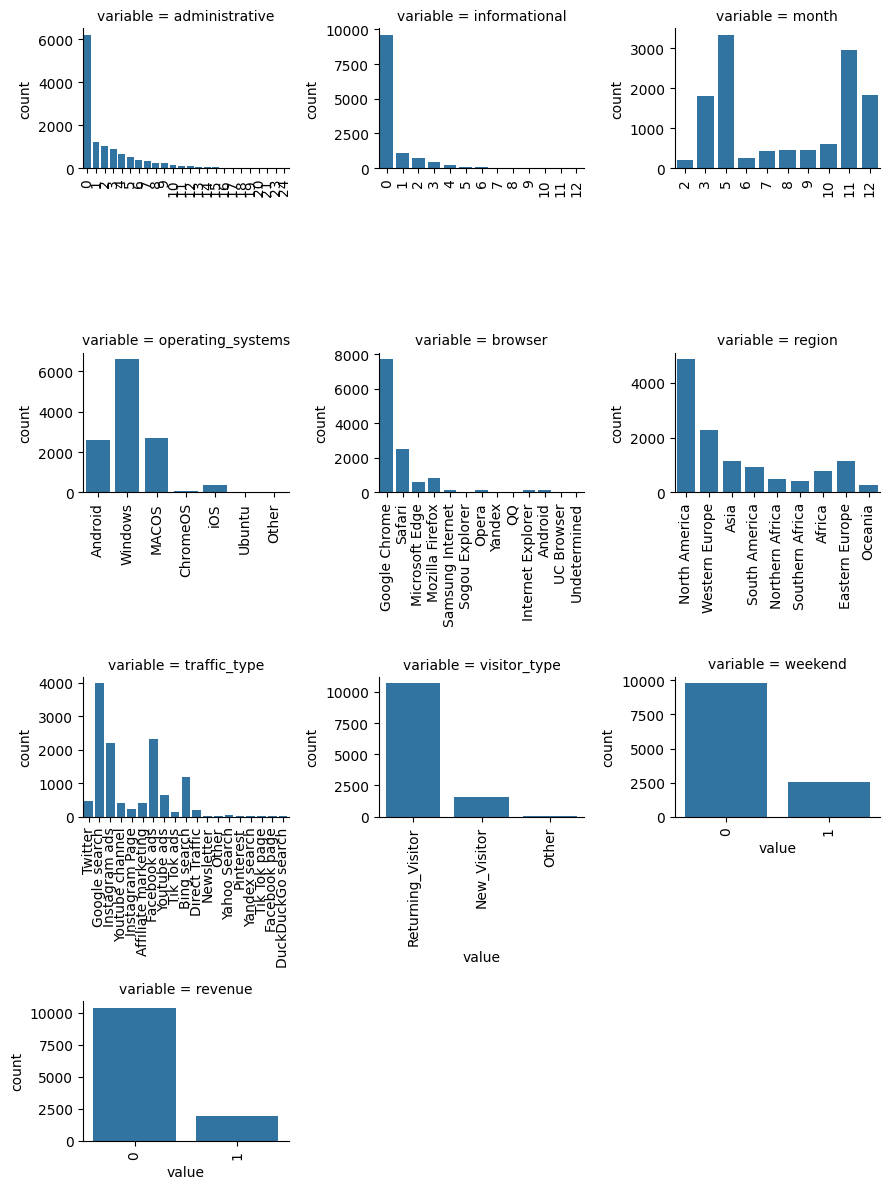

In [23]:
numeric_features_2 = ['administrative_duration',
                    'informational_duration',
                    'product_related_duration',
                    'bounce_rates',
                    'exit_rates',
                    'page_values',
                    'product_related' # not numeric really, but does not render well
                    ]
plotter = Plotter(cleaned_df)
categorical_features = info_extractor.extract_categorical_features(numeric_features_2)
plotter.count_plots_grid(categorical_features)

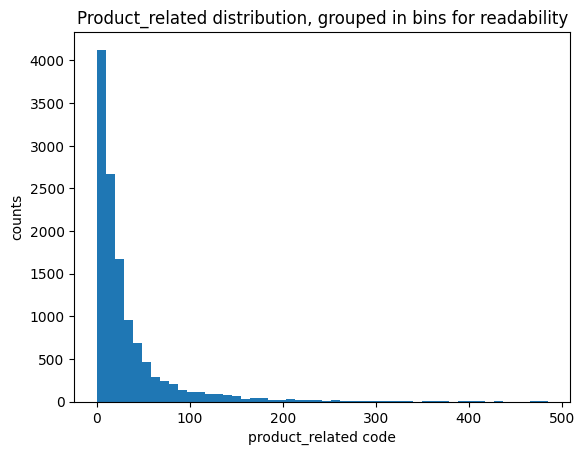

In [24]:
cleaned_df['product_related'].hist(bins = 50, grid=False)
plt.title('Product_related distribution, grouped in bins for readability')
plt.xlabel('product_related code')
plt.ylabel('counts')
plt.show()

#### 2.3. Distributions of numerical columns

+--------------------------+--------------------+
|          Column          |      Skewness      |
+--------------------------+--------------------+
| administrative_duration  |  4.66660795732664  |
|  informational_duration  | 7.202649853929625  |
| product_related_duration | 3.643645285073337  |
|       bounce_rates       | 2.949097435579563  |
|        exit_rates        | 2.1944198114402966 |
|       page_values        | 6.023549371882267  |
+--------------------------+--------------------+


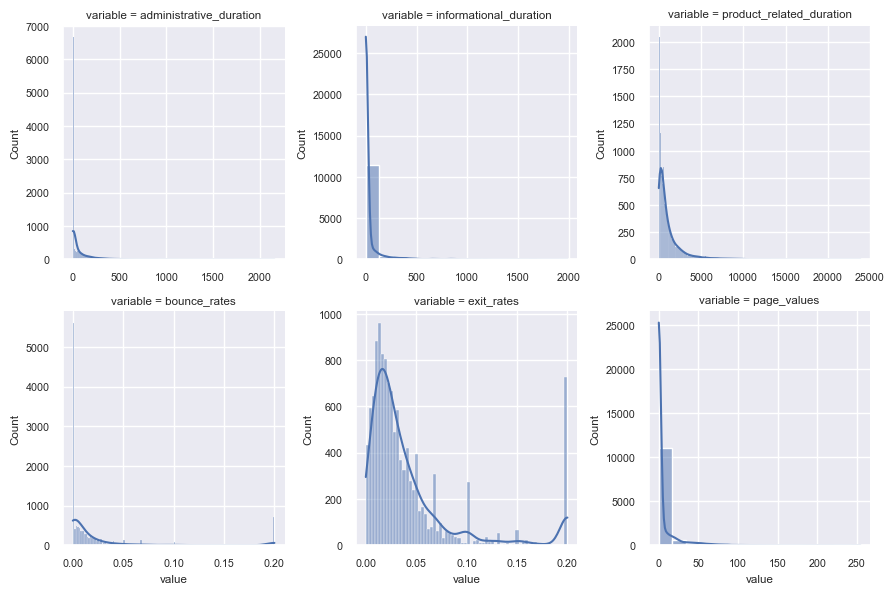

In [25]:
# NOTE Nice annotations on the graphs
numeric_features = ['administrative_duration',
                    'informational_duration',
                    'product_related_duration',
                    'bounce_rates',
                    'exit_rates',
                    'page_values',
                    ]

plotter.numeric_distributions_grid(numeric_features)
info_extractor.data_skewness_values(numeric_features)

##### **Zero-Inflated distributions**
They are a mixture of 2 distributions: 
- A binomial distribution: the event happened (1) or did not happen (0)
- A continuous distribution: when the event happened, what's the distribution of values (duration, rates, etc.)

1. Task duration columns: 0 implies that task was not done at all.
1. Rate columns: peak at 0 might mean the page did not load before bouncing back. Pick at maximum rate will mean thouse customers this not bounce back or exit the page.


Checking the distributions and skew of continuous numerical data

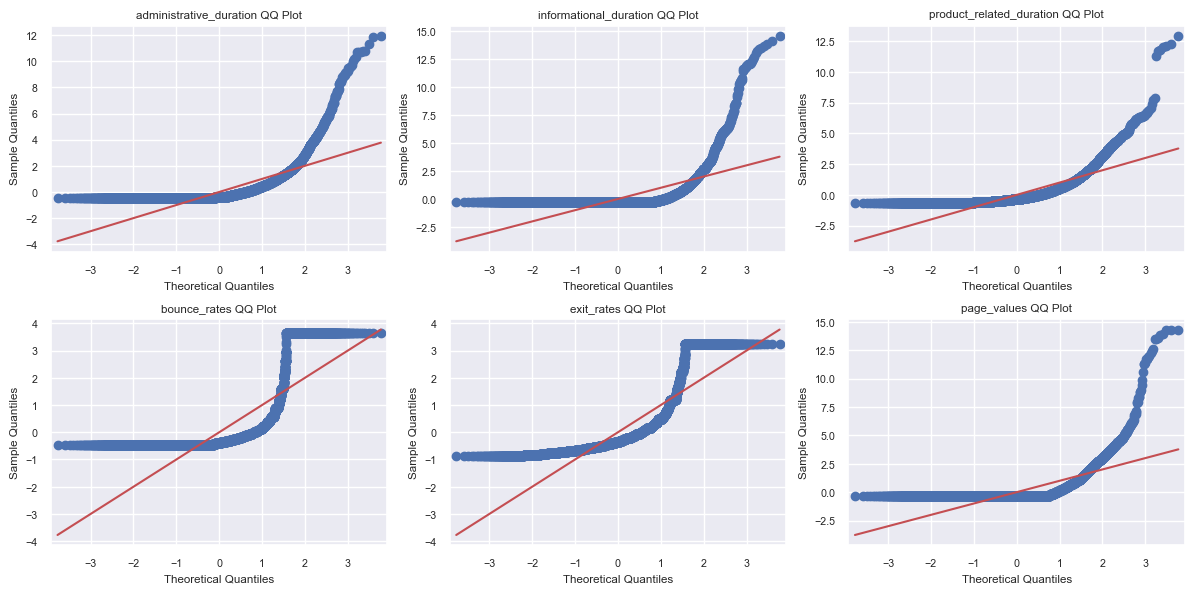

In [26]:
plotter.multi_qq_plot(numeric_features)

**Data Skewness: Q-Q plots**

All numerical data has high positive skew meaning that the values are greatly over represented by outliers. Also the mean and median are much higher than the mode. 

- Variables `administrative_duration`, `informational_duration` and `product_related_duration` are highly skewed towards zero, as zero is the value given when a specific task has not been performed. Some of the transformations below will not take into account the presence of zero values when transforming and calculating the skewness.

- Variable `bounce_rates` is also skewed towards zero as some website users will have stayed on the website instead of bouncing baack.

- Variable `exit_rates` has a high peak at 0.20. This could be because the website does not measure exit rates higher than that value, and users that stay for long periods of time on the website are under the maximum measurable value.

#### 2.4. Variable-variable relationships

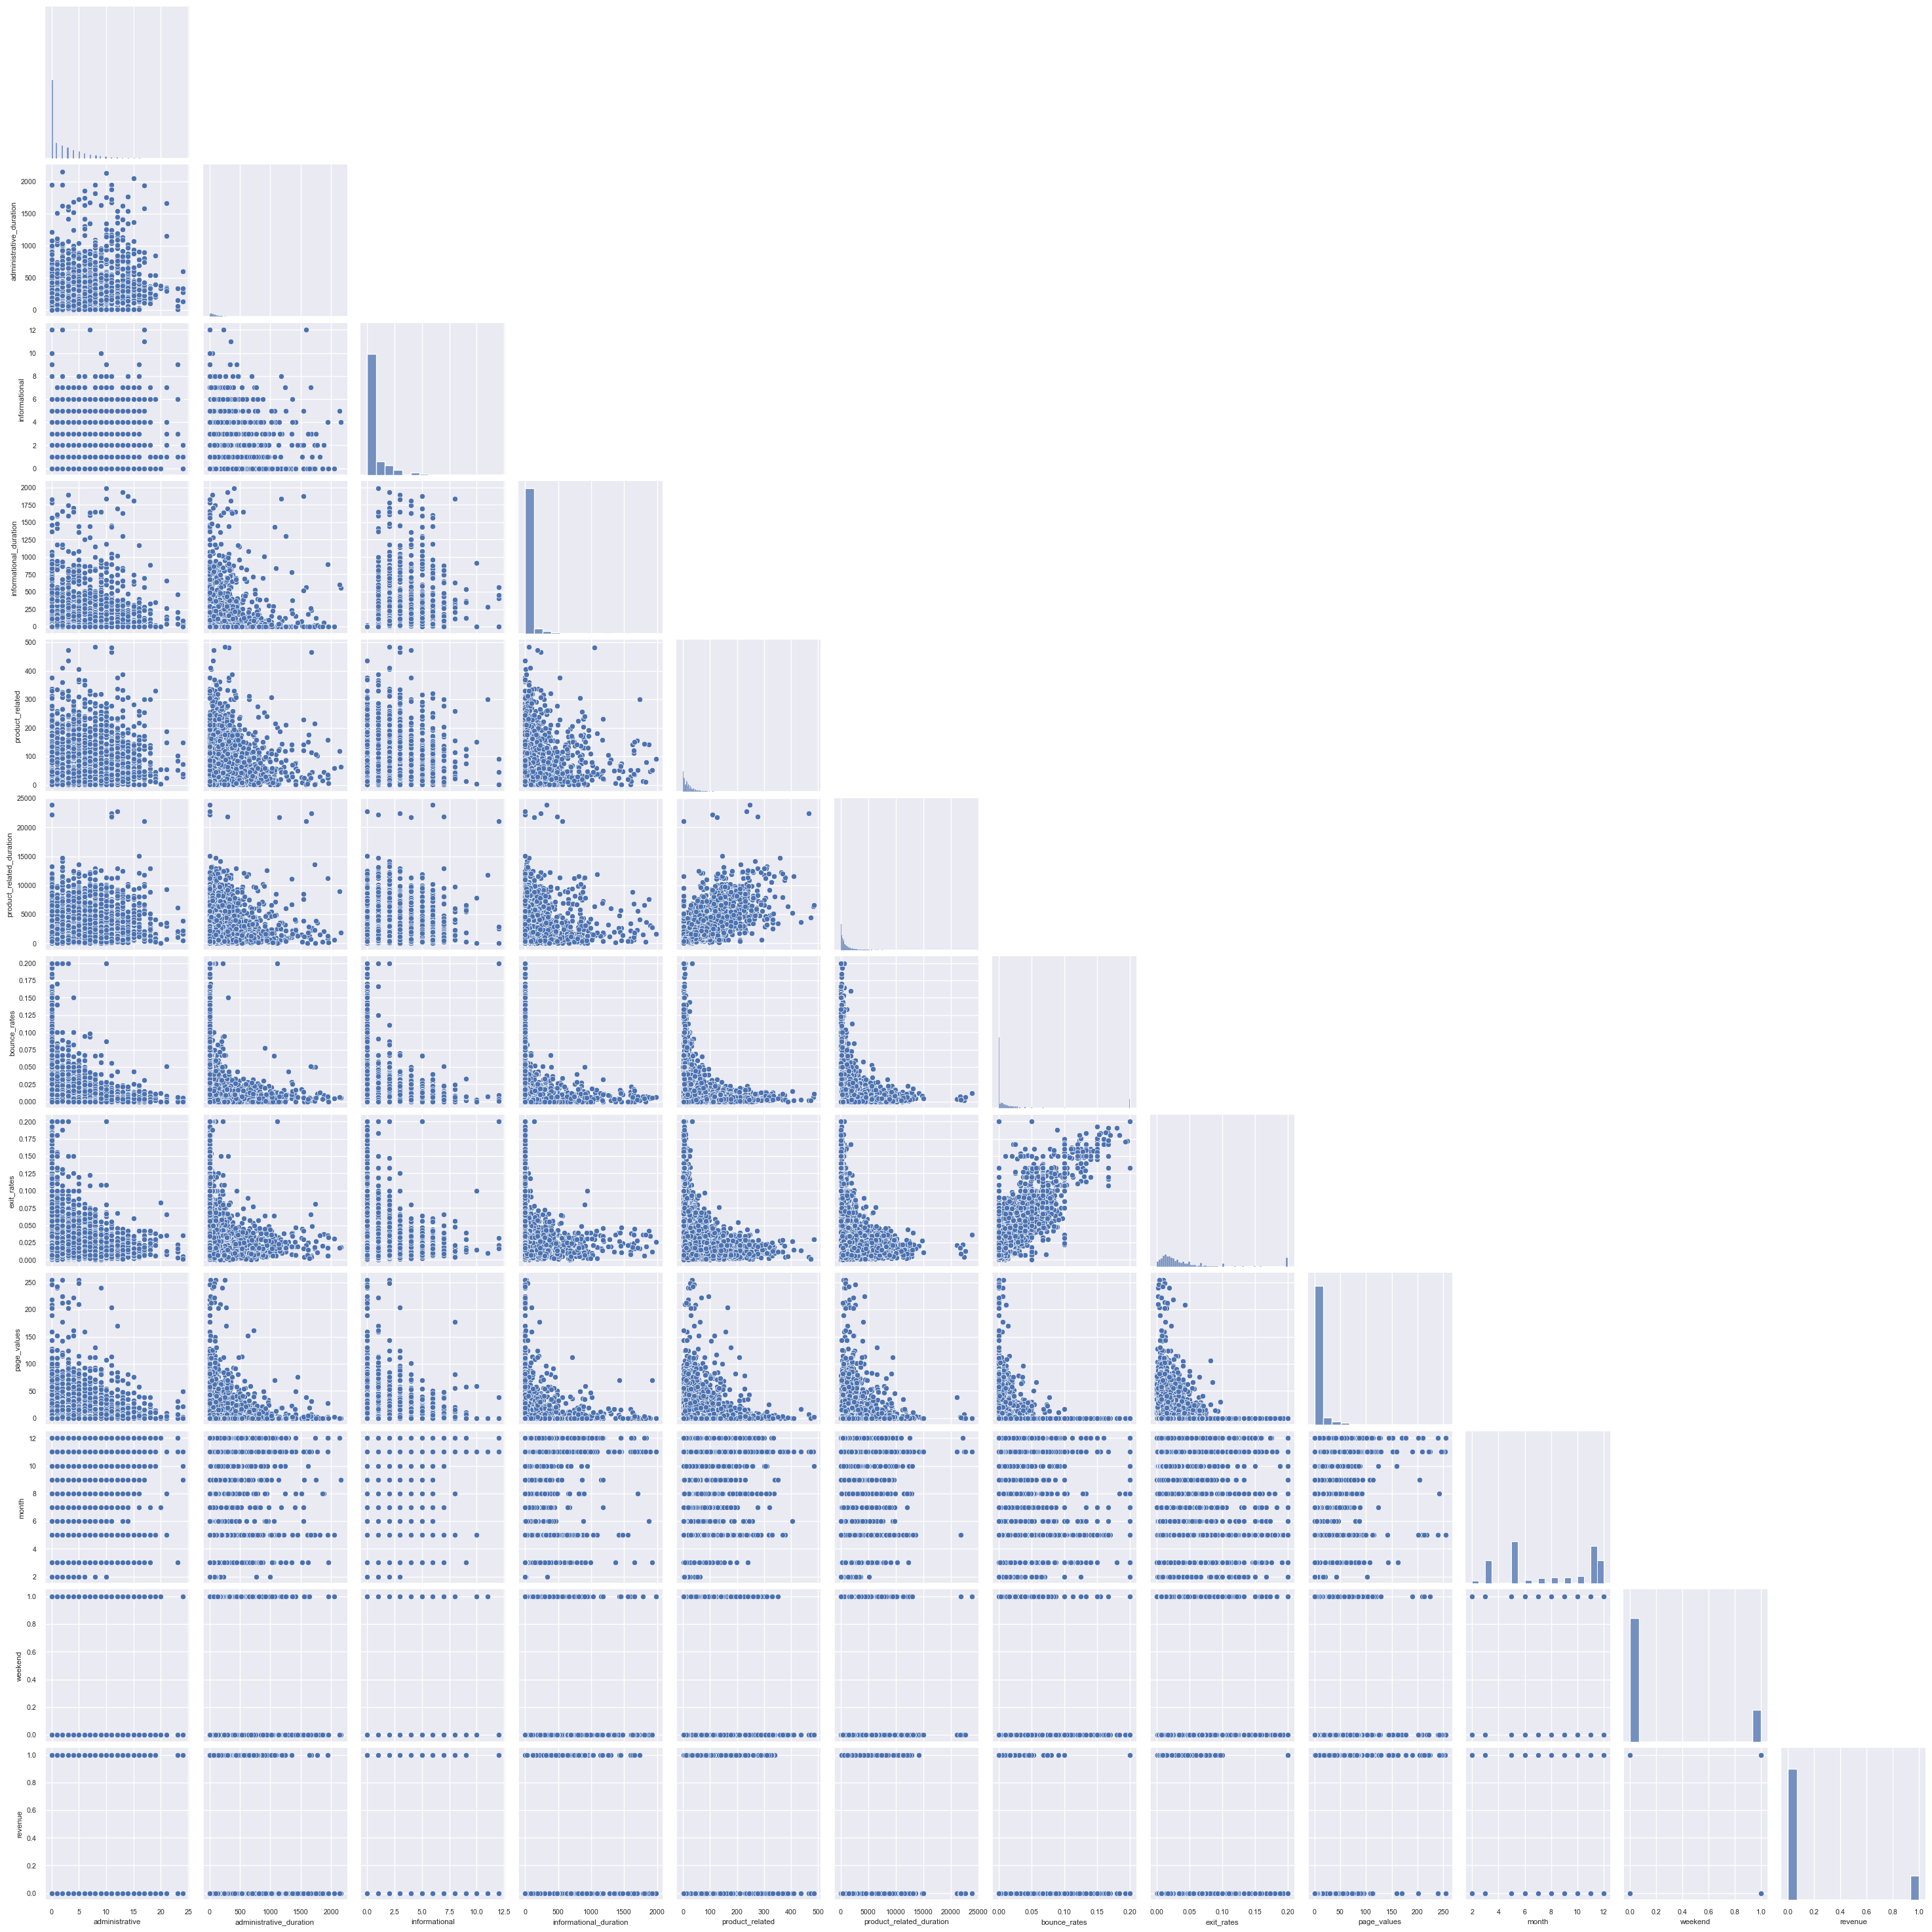

In [27]:
sns.pairplot(cleaned_df, corner=True)

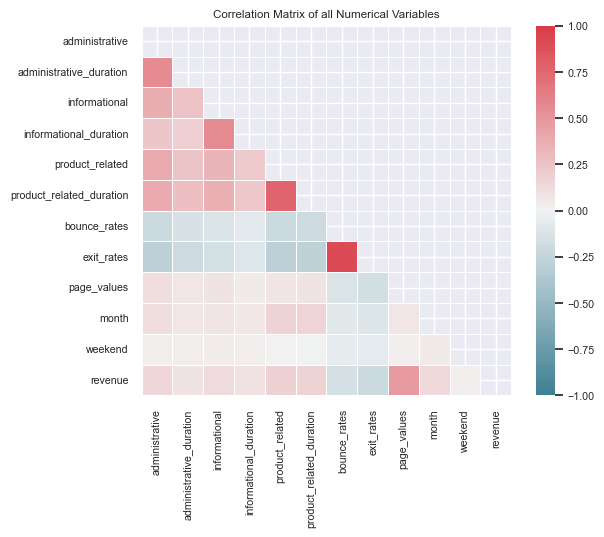

In [28]:
plotter = Plotter(cleaned_df)
plotter.correlation_matrix_df()

**Insights**

- There is some degree of correlation (medium strength) between the product_related task done and the time spent doing it. This makes sense, as some each product and product page will have different characteristics. Some products might require longer time to convince the user, or might be more popular than others. 

- Bounce rates and exit rates are highly positively correlated, r = 0.91.

- There's a number of product_related tasks that do not bring any revenue. Investigate.

### **Part III: Preparing the data for Machine Learning Applications**

#### 3.1. Feature Enginnering: Correcting skew in numerical columns


In [29]:
transformer = DataTransform(cleaned_df)
ML_preprocessed_df = transformer.log_transform(['bounce_rates','exit_rates','administrative_duration','informational_duration'])
ML_preprocessed_df = transformer.yeo_johnson_transform(['product_related_duration','page_values'])

+--------------------------+----------------------+
|          Column          |       Skewness       |
+--------------------------+----------------------+
| administrative_duration  | 0.33942923903904537  |
|  informational_duration  |  1.9073245666767467  |
| product_related_duration | -0.6594126719704976  |
|       bounce_rates       | -0.27337844121799487 |
|        exit_rates        | 0.12578915345240188  |
|       page_values        |  1.8245208888545068  |
+--------------------------+----------------------+


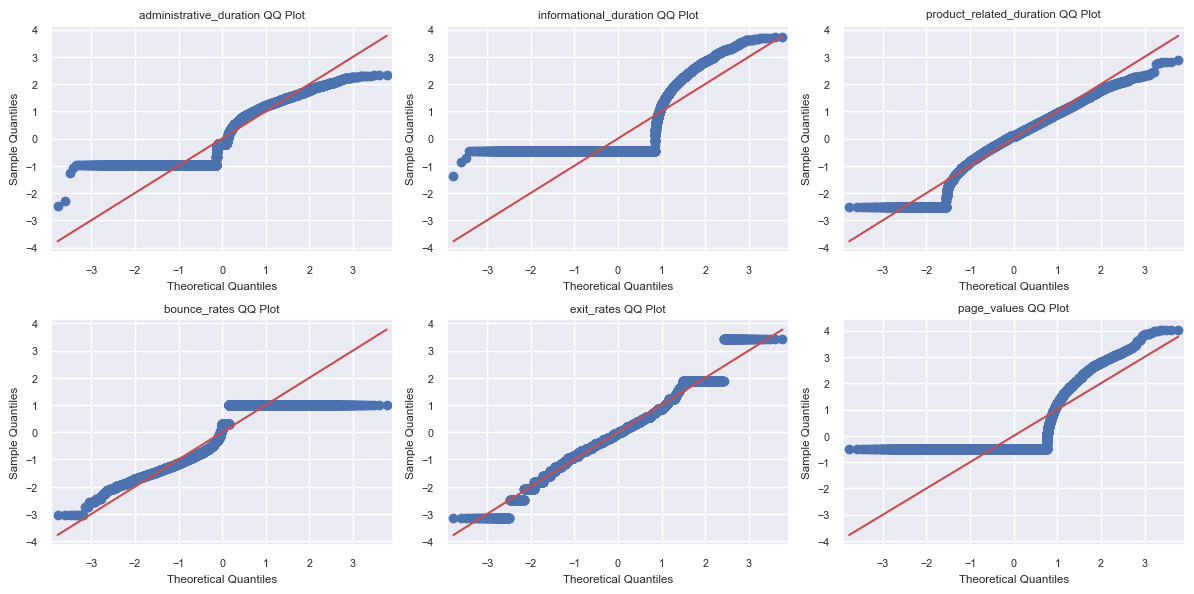

In [30]:
plotter = Plotter(ML_preprocessed_df)
info_extractor = DataFrameInfo(ML_preprocessed_df)
plotter.multi_qq_plot(numeric_features)
info_extractor.data_skewness_values(numeric_features)

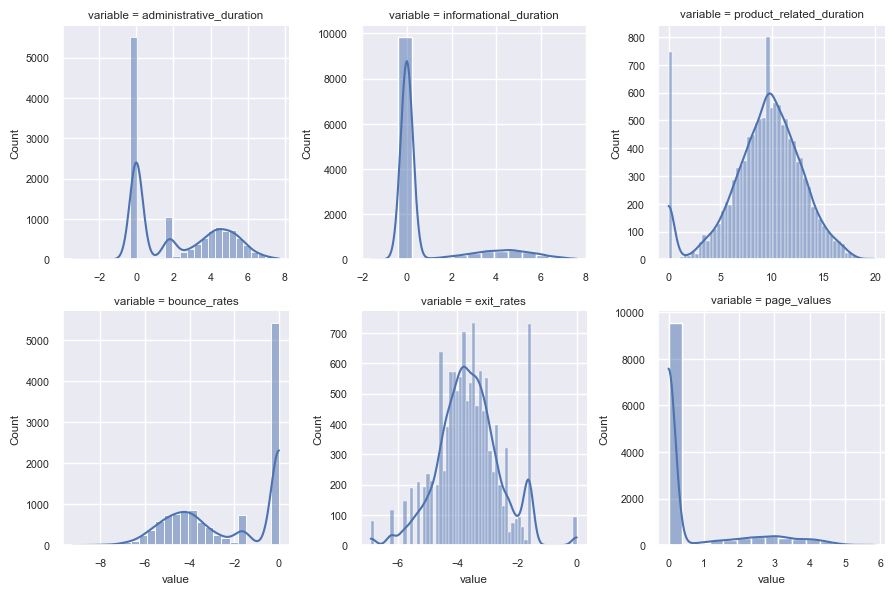

In [31]:
plotter.numeric_distributions_grid(numeric_features)

Results above are not ideal: depending on the modelling required, I would filter out the zeros (even did not happen). This would depend on requirements though, and more extensive domain knowledge of this dataset.

#### 3.1. Avoiding multicollinearity: dropping overly correlated columns

To decide which columns to drop we need to compare the VIF (Variance inflation factor) of each column against all remaining columns. Whichever column is contributing the most to the VIF factor can be dropped. VIF > 5 should be inspected.

In [32]:
# the independent variables set 
X = cleaned_df[['administrative', 'administrative_duration', 'informational', 'informational_duration', 
                'product_related', 'product_related_duration', 'bounce_rates', 'exit_rates', 'page_values','weekend','revenue']] 
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

                     feature       VIF
0             administrative  2.362956
1    administrative_duration  1.761928
2              informational  1.936399
3     informational_duration  1.526346
4            product_related  3.690174
5   product_related_duration  3.674041
6               bounce_rates  5.609860
7                 exit_rates  6.022743
8                page_values  1.425008
9                    weekend  1.190258
10                   revenue  1.557914


In [33]:
column_to_drop = 'exit_rates'
ML_preprocessed_df.drop(column_to_drop, axis=1, inplace=True)
ML_preprocessed_df.columns

Index(['administrative', 'administrative_duration', 'informational',
       'informational_duration', 'product_related', 'product_related_duration',
       'bounce_rates', 'page_values', 'month', 'operating_systems', 'browser',
       'region', 'traffic_type', 'visitor_type', 'weekend', 'revenue'],
      dtype='object')

#### 3.3. Detecting Outliers

- CATEGORICAL VARIABLES: First, we can check for outliers in the categorical variables by inspecting the type of values and also by plotting their frequency distributions (see above). If a category is very infrequent, it could be considered an outlier. I have decided not to remove any values or categories here. I will take care of any necessary filtering and groupings in the analysis.

- NUMERICAL VARIABLES: I have done some quick check with IQR and z-scores, but I decided to leave outlier checking during the analysis of the data. Using this method, there seems to be a very high number of outliers for some of the numerical columns (see below).


In [34]:
# Good analysis of the categorical columns
# NOTE Absolutely fine to leave removal of the outliers if you feel their values are true outliers.
outliers = OutlierDetector(ML_preprocessed_df) 
col = ['product_related_duration', 'informational_duration','administrative_duration','page_values','bounce_rates']
outliers.IQR_outliers(col)


Results for product_related_duration column:
Q1 (25th percentile): 7.442823332666648
Q3 (75th percentile): 11.685023453065885
IQR: 4.242200120399237

Outliers:
shape: (760, 16)

Results for informational_duration column:
Q1 (25th percentile): 0.0
Q3 (75th percentile): 0.0
IQR: 0.0

Outliers:
shape: (2465, 16)

Results for administrative_duration column:
Q1 (25th percentile): 0.0
Q3 (75th percentile): 4.454347296253507
IQR: 4.454347296253507

Outliers:
shape: (0, 16)

Results for page_values column:
Q1 (25th percentile): 0.0
Q3 (75th percentile): 0.0
IQR: 0.0

Outliers:
shape: (2779, 16)

Results for bounce_rates column:
Q1 (25th percentile): -4.374058465024705
Q3 (75th percentile): 0.0
IQR: 4.374058465024705

Outliers:
shape: (0, 16)


Calculating z-scores is a different way to detect outliers in continuous data with a **normal distribution**. The z-score is a measure of how many standard deviation a certain measure is away from the mean. Values more than 3 standards deviations away from the mean can be considered outliers.

In [35]:
numeric_cols = ['administrative_duration',
                'informational_duration',
                'product_related_duration',
                'bounce_rates',
                'page_values',
                ]

# The following only applies if the variables are normally distributed:
# for column in numeric_cols:
#    df = outliers.z_scores(column)
#    df = df[(df['z-scores'] < -3) | (df['z-scores'] > 3)]
#    print(df)

## Download processed datasets to local folder as .csv

In [37]:
# ML_preprocessed_data = ML_preprocessed_df.copy()
# ML_preprocessed_data.to_csv("data/ML_preprocessed_data.csv")
# customer_web_data = cleaned_df.copy()
# customer_web_data.to_csv("data/customer_web_data_clean.csv")